# The Heart of the Matter: Analyzing Predictors of Heart Disease



## Introduction

Heart disease is the number 1 cause of deaths worldwide, with no 'cure' of any kind. We can, however, try to identify possible factors that lead to higher risk of heart disease. We obtained a set of data collected by Robert Detrano, (M.D., Ph.D.) from the Long Beach and Cleveland Clinic Foundation. This data set contains a total of 76 attributes, of which 14 are used as primary data. We will be using this data to craft a model that attempts to predict whether or not age, sex, total cholestoral levels, maximum heart rate and number of major vessels affected by flourosopy affect the diagnosis of heart disease. 

## Preliminary exploratory data analysis

In [7]:
library(tidyverse)
library(tidymodels)
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [8]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
download.file(url, destfile = "data/processed.cleveland.data")
heart_df <- read_csv("data/processed.cleveland.data", col_name = FALSE)
col <- c("age", "sex","cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal","num")
colnames(heart_df) <- col
head(heart_df)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


We will extract the columns that we need and prepare them for analysis. Make the "num" variable binary by reducing the number of categories.

In [9]:
filheart_df <- select(heart_df, -cp, -trestbps, -fbs, -restecg, -exang, -oldpeak, -slope, -thal)
head(filheart_df)

heart_num0 <- filheart_df |>
filter(num == 0)
heart_num1 <- filheart_df |>
filter(num > 0) |>
mutate(num = 1)

heart_clean <- rbind(heart_num0, heart_num1)
heart_clean <- heart_clean |>
mutate(num = as_factor(num), ca = as.integer(ca), sex = as_factor(sex))
head(heart_clean)

age,sex,chol,thalach,ca,num
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
63,1,233,150,0.0,0
67,1,286,108,3.0,2
67,1,229,129,2.0,1
37,1,250,187,0.0,0
41,0,204,172,0.0,0
56,1,236,178,0.0,0


Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,chol,thalach,ca,num
<dbl>,<fct>,<dbl>,<dbl>,<int>,<fct>
63,1,233,150,0,0
37,1,250,187,0,0
41,0,204,172,0,0
56,1,236,178,0,0
57,0,354,163,0,0
57,1,192,148,0,0


In [10]:
# Here we use prop = 0.7 but we may change as we build our model
split <- initial_split(heart_clean, prop = 0.7, strata = num)
heart_train <- training(split)
heart_test <- testing(split)
# head(heart_train)
# head(heart_test)

### Summary of predictor variables
We report counts for categorical variables and means for quantitative variables as well as the number of NA values for each variable.

In [11]:
num_counts <- heart_train |>
    group_by(num) |>
    summarize(count = n())
ca_counts <- heart_train |>
    group_by(ca) |>
    summarize(count = n())
means_by_num  <- heart_train %>%
        group_by(num) %>%
        summarize(avg_age = mean(age), avg_chol = mean(chol), avg_thal = mean(thalach))
print("Diagnosis Counts")
num_counts
print("Flourosopy Counts")
ca_counts
print("Means of Quantitative Variables Based on Diagnosis")
means_by_num

[1] "Diagnosis Counts"


num,count
<fct>,<int>
0,114
1,97


[1] "Flourosopy Counts"


ca,count
<int>,<int>
0,123
1,46
2,25
3,14
NA,3


[1] "Means of Quantitative Variables Based on Diagnosis"


num,avg_age,avg_chol,avg_thal
<fct>,<dbl>,<dbl>,<dbl>
0,52.26316,244.7193,159.7281
1,57.09278,249.5052,137.7526


### Visualization
We visualize the distribution of each column. Some rough trends can be observed just by colouring based on the presence of heart disease.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 3 rows containing non-finite values (stat_count).”


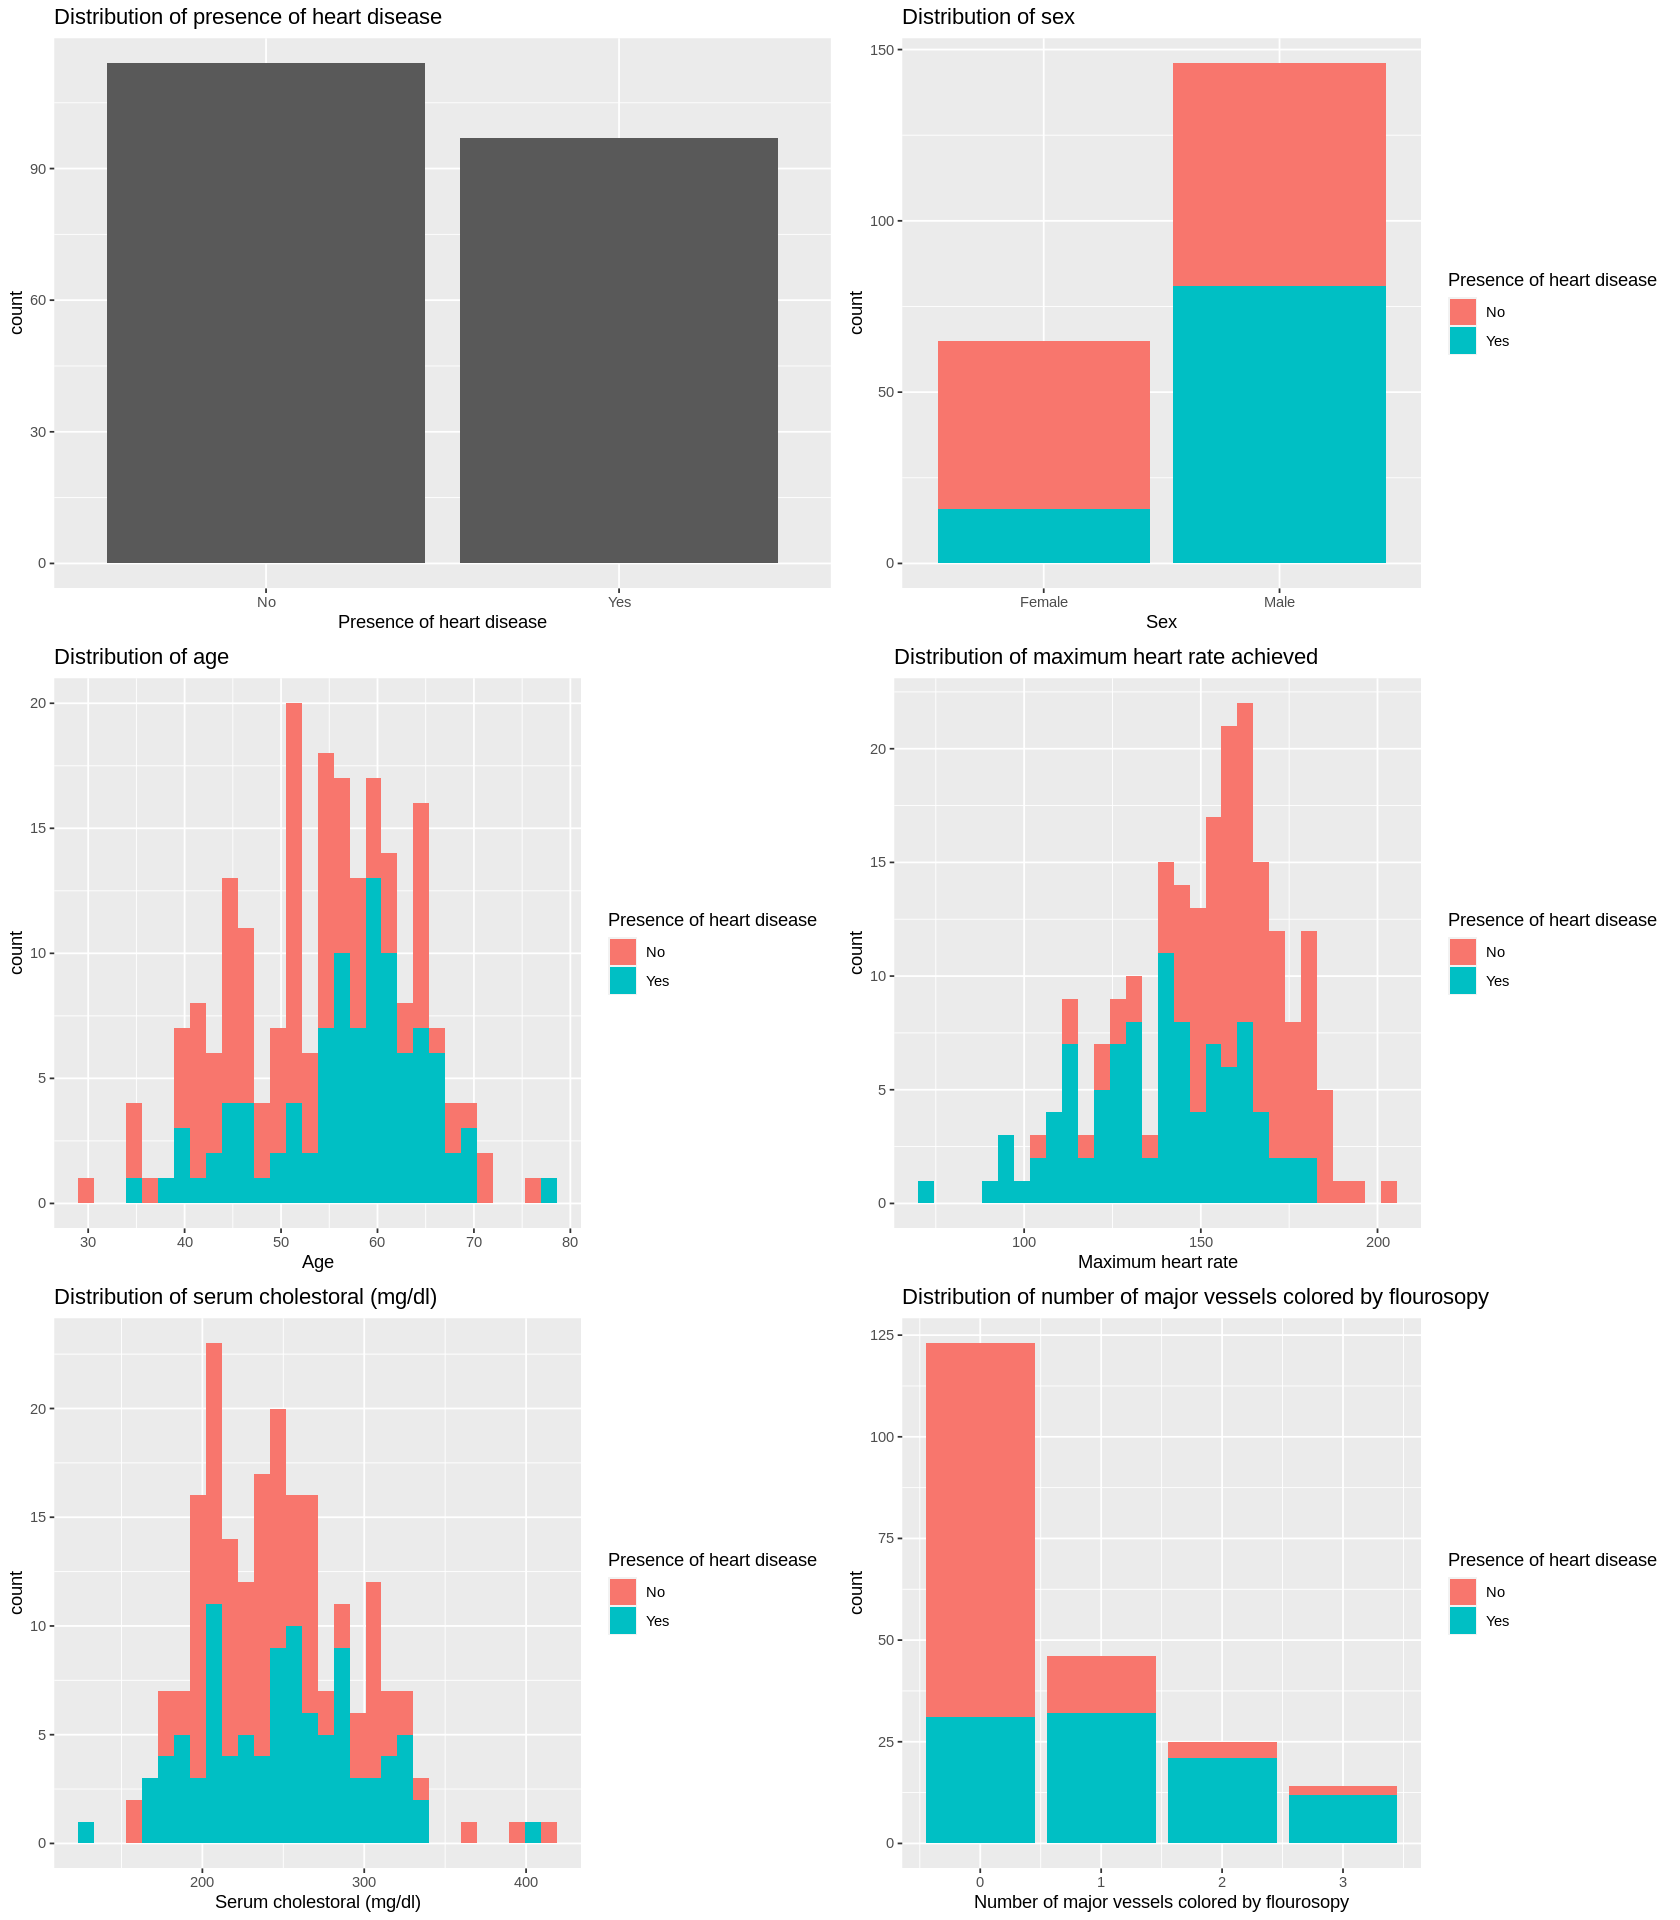

In [12]:
num_plot <- ggplot(heart_train, aes(x = num)) +
    geom_bar() +
    labs(x = "Presence of heart disease", title = "Distribution of presence of heart disease")+
    scale_x_discrete(labels = c('No','Yes'))

sex_plot <- ggplot(heart_train, aes(x= sex, fill = num)) +
    geom_bar(position = "stack") + 
    labs(x = "Sex", title = "Distribution of sex", fill = "Presence of heart disease") +
    scale_fill_hue(labels = c("No", "Yes"))+
    scale_x_discrete(labels = c('Female','Male'))


age_plot <- ggplot(heart_train, aes(x= age, fill = num)) +
    geom_histogram(position = "stack") +
    labs(x = "Age", title = "Distribution of age", fill = "Presence of heart disease") +
    scale_fill_hue(labels = c("No", "Yes"))


chol_plot <- ggplot(heart_train, aes(x= chol, fill = num)) +
    geom_histogram(position = "stack") +
    labs(x = "Serum cholestoral (mg/dl)", title = "Distribution of serum cholestoral (mg/dl)", fill = "Presence of heart disease") +
    scale_fill_hue(labels = c("No", "Yes"))


thalach_plot <- ggplot(heart_train, aes(x= thalach, fill = num)) +
    geom_histogram(position = "stack") +
    labs(x = "Maximum heart rate", title = "Distribution of maximum heart rate achieved", fill = "Presence of heart disease") +
    scale_fill_hue(labels = c("No", "Yes"))


ca_plot <- ggplot(heart_train, aes(x= ca, fill = num)) +
    geom_bar(position = "stack")+
    labs(x = "Number of major vessels colored by flourosopy", title = "Distribution of number of major vessels colored by flourosopy", fill = "Presence of heart disease") +
    scale_fill_hue(labels = c("No", "Yes"))

options(repr.plot.width = 14, repr.plot.height = 16)
grid.arrange(num_plot, sex_plot, age_plot,thalach_plot, chol_plot, ca_plot, ncol = 2)

## Methods

We will use k-nearest neighbours classification algorithm to predict the instance of heart disease with our chosen factors. We will be using age (age), sex (sex), cholesterol level(in mg/dl) (chol), maximum heart rate achieved (thalach), and number of major vessels colored by flourosopy
 (ca) to predict the diagnosis of heart disease (num). For clarity, sex is a binary variable that is coded as male = 1 and female = 0. Number of major vessels is measured from 0-3 and converted to integers. The diagnosis is initially measured from 0-4: 0 indicating no presence and 1-4 indicating presence of heart disease. We mutated this into a binary variable so that 0 indicates no diagnosis and 1 indicates diagnosis. 

We will find the best k by using cross validation with some number of folds to achieve a better accuracy. Accuracy will be determined by how correctly our model can predict the presence of heart disease with unseen data (test set).

One way to visualize our results is to create a scatterplot between two variables that were found to have a significant influence in prediction with the color function to indicate the instance of heart disease or not. This will help explain why our model works (or doesn’t work very well) because we can see the relationships between the predictors and the target variable.

## Expected outcomes and significance

We expect to find relationship between our predictors (age, cholesterol level, maximum heart rate achieved, number of major vessels colored by flourosopy, and sex) and our target variable (presence of heart disease).

Findings such as this could have an impact on how doctors communicate health risks to patients. It may also affect how patients change their daily life as certain factors, such as cholesterol level, may be found to be associated with higher chances of heart disease.

This could lead to future questions about the compounding effect of these variables and all other variables that serve predictive purposes. Knowing how these chosen variables affect the instance of heart disease, questions about other predictive variables such as blood pressure, smoking, or obesity can also be tested individually and together. Interactions between these variables could be a very important question to the future of diagnostic research with regard to heart disease and other similar conditions.
